In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.svm import SVC

In [2]:
experiment_setups = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'n_estimators': [200, 350, 500],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [4, 5, 7, 8],
            'criterion': ['gini', 'entropy']
        }
    },
    'SVC': {
        'model': SVC(),
        'param_grid': {
            'C': [0.01, 0.1, 1.0, 10, 100],
            'kernel': ["rbf"],
            'gamma': [0.01, 0.1, 1.0, 10, 100]
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'param_grid': {
            'metric': ['minkowski', 'euclidean', 'manhattan'],
            'weights': ['uniform', 'distance'],
            'n_neighbors': np.arange(5, 10)
        }
    },
}

In [3]:
Q_PERCENTS = [20, 30, 40, 50, 60, 70, 80, 90, 100]

In [4]:
acc_df = pd.DataFrame(columns=list(experiment_setups.keys()), index=Q_PERCENTS)

In [5]:
DATASETS_DIR = 'DATASETS'

In [6]:
for q_percent in Q_PERCENTS:

    print(f'{" q = " + str(q_percent) + "% ":=^80}')

    df = pd.read_csv(f'{DATASETS_DIR}/q={q_percent}%.csv')

    df[df.columns[:-1]] = scale(df[df.columns[:-1]])

    df_train, df_test = train_test_split(df, test_size=0.3)

    y_train = df_train.pop('noised')
    X_train = df_train
    y_test = df_test.pop('noised')
    X_test = df_test

    for model_name, model_data in experiment_setups.items():
        print(f'{model_name:-^80}')

        gs = GridSearchCV(estimator=model_data['model'],
                             param_grid=model_data['param_grid'],
                             scoring='accuracy',
                             cv=5,
                             verbose=1,
                             n_jobs=-1)

        gs.fit(X_train, y_train)

        print(f'GridSearch: acc = {gs.best_score_}, best_params = {gs.best_params_}')

        print('on test data:')
        y_pred = gs.best_estimator_.predict(X_test)
        acc_value = accuracy_score(y_test, y_pred)
        print(f'acc = {acc_value}')
        print(f'{classification_report(y_test, y_pred)}')
        acc_df.loc[q_percent, model_name] = acc_value

=================================== q = 20% ====================================
-----------------------------RandomForestClassifier-----------------------------
Fitting 5 folds for each of 48 candidates, totalling 240 fits
GridSearch: acc = 0.647142857142857, best_params = {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 500}
on test data:
acc = 0.6866666666666666
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       145
           1       0.70      0.68      0.69       155

    accuracy                           0.69       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.69      0.69      0.69       300

--------------------------------------SVC---------------------------------------
Fitting 5 folds for each of 25 candidates, totalling 125 fits
GridSearch: acc = 0.5857142857142856, best_params = {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
on test data:
acc = 0.6533333333333333

In [7]:
acc_df

,RandomForestClassifier,SVC,KNeighborsClassifier
20,0.686667,0.653333,0.566667
30,0.696667,0.653333,0.65
40,0.76,0.703333,0.61
50,0.77,0.73,0.64
60,0.903333,0.856667,0.75
70,0.873333,0.873333,0.75
80,0.953333,0.923333,0.853333
90,0.97,0.963333,0.873333
100,0.99,0.973333,0.886667


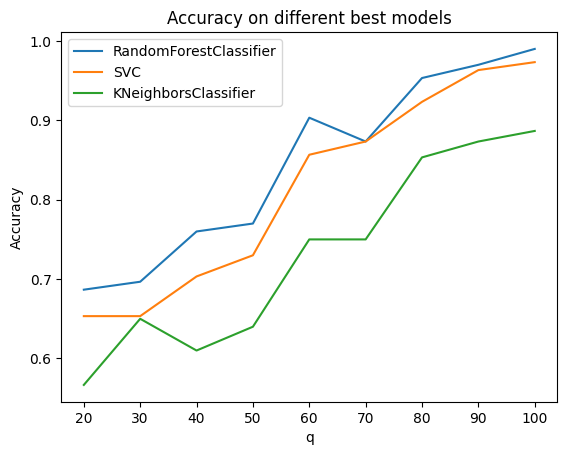

In [8]:
acc_df.plot(title="Accuracy on different best models", xlabel="q", ylabel="Accuracy")
print()